In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, csr_matrix
from scipy.sparse.csgraph import connected_components, shortest_path
import requests
import zipfile
import io
import os
import random
from scipy.stats import pearsonr
from scipy.sparse.linalg import eigsh


# Question 1a

In [128]:
DATA_URL = "https://networksciencebook.com/translations/en/resources/networks.zip"
DATA_DIR = "data"

def download_datasets():
    """Minimal downloader: save DATA_URL to data/networks.zip and extract it."""
    os.makedirs(DATA_DIR, exist_ok=True)
    zip_path = os.path.join(DATA_DIR, "networks.zip")

    resp = requests.get(DATA_URL, timeout=30)
    resp.raise_for_status()

    with open(zip_path, "wb") as f:
        f.write(resp.content)

    # basic sanity check and extraction
    if not resp.content[:2] == b"PK":
        raise RuntimeError(f"Downloaded file does not look like a ZIP (first bytes: {resp.content[:32]!r})")

    with zipfile.ZipFile(zip_path) as z:
        z.extractall(DATA_DIR)


def load_edge_list(file_path):
    edges = np.loadtxt(file_path, dtype=int)
    return edges

def create_simple_undirected_adjacency(edges):
    if edges.min() == 1:
        edges = edges - 1

    edges = edges[edges[:, 0] != edges[:, 1]]

    edges = np.sort(edges, axis=1)

    edges = np.unique(edges, axis=0)

    num_nodes = edges.max() + 1

    A = csc_matrix(
    (np.ones(len(edges)), (edges[:, 0], edges[:, 1])),
    shape=(num_nodes, num_nodes)
    )

    A = A + A.T

    return A


def compute_graph_metrics(adj_matrix):
    num_components, labels = connected_components(adj_matrix, directed=False)

    component_sizes = np.bincount(labels)
    largest_component_size = component_sizes.max()

    num_nodes = adj_matrix.shape[0]
    num_edges = adj_matrix.nnz // 2

    return {
        "Number of Nodes": int(num_nodes),
        "Number of Edges": int(num_edges),
        "Number of Components": int(num_components),
        "Largest Component Size": int(largest_component_size),
    }

In [129]:
#download_datasets()

edges = load_edge_list("data/internet.edgelist.txt")
A = create_simple_undirected_adjacency(edges)
metrics = compute_graph_metrics(A)

print(metrics)

{'Number of Nodes': 192244, 'Number of Edges': 609066, 'Number of Components': 308, 'Largest Component Size': 190914}


# Question 1b

In [130]:
def compute_degree_distribution(adj_matrix):
	# degree for undirected graph
	degrees = np.asarray(adj_matrix.sum(axis=1)).ravel().astype(int)

	# count occurrences of each degree
	degree_values, degree_counts = np.unique(degrees, return_counts=True)

	return degree_values, degree_counts


def fit_power_law(degree_values, degree_counts, kmin=1):
	# remove k=0 (log(0) undefined) and filter on kmin
	mask = (degree_values >= kmin) & (degree_values > 0) & (degree_counts > 0)
	x = degree_values[mask]
	y = degree_counts[mask]

	if len(x) < 2:
		raise ValueError("Not enough data points to fit a power law. Try lowering kmin.")

	log_x = np.log(x)
	log_y = np.log(y)

	slope, intercept = np.polyfit(log_x, log_y, 1)
	return slope, intercept


def plot_degree_distribution(degree_values, degree_counts, slope, intercept):
	plt.figure(figsize=(8, 6))

	# plot degree distribution (counts)
	plt.scatter(degree_values, degree_counts, label="Degree Distribution", alpha=0.6)

	# fitted power-law line
	log_degrees = np.log(degree_values[degree_values > 0])
	fitted_line = np.exp(intercept + slope * log_degrees)
	plt.plot(degree_values[degree_values > 0], fitted_line, label=f"Power-law Fit (slope={slope:.2f})")

	plt.xscale("log")
	plt.yscale("log")
	plt.xlabel("Degree k")
	plt.ylabel("Count")
	plt.title("Degree Distribution (log-log) with Power-law Fit")
	plt.legend()
	plt.grid(True, which="both", linestyle="--", linewidth=0.5)
	plt.tight_layout()
	plt.show()

Power-law fit slope (log(count) vs log(k)): -2.1490


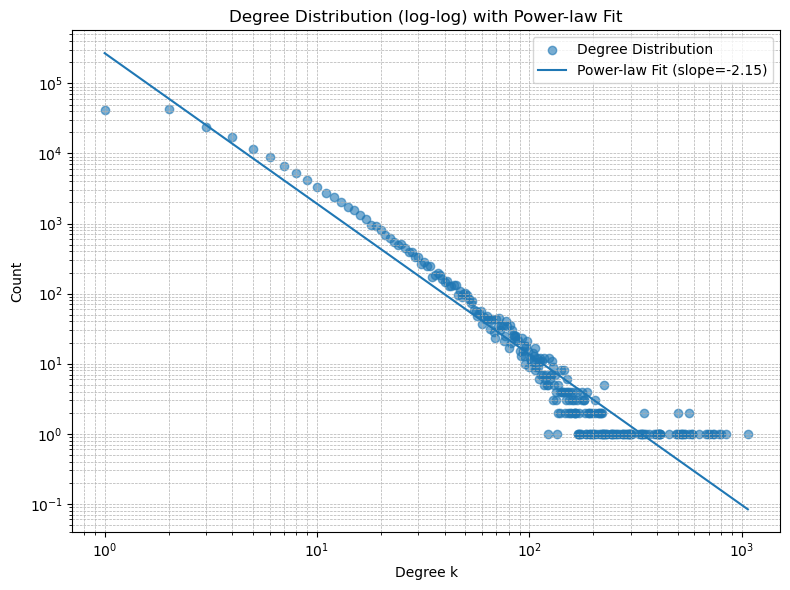

In [131]:
degree_values, degree_counts = compute_degree_distribution(A)
slope, intercept = fit_power_law(degree_values, degree_counts, kmin=1)
print(f"Power-law fit slope (log(count) vs log(k)): {slope:.4f}")
plot_degree_distribution(degree_values, degree_counts, slope, intercept)

# Question 1c

Average shortest path length (reachable pairs only, sampled): 7.0765


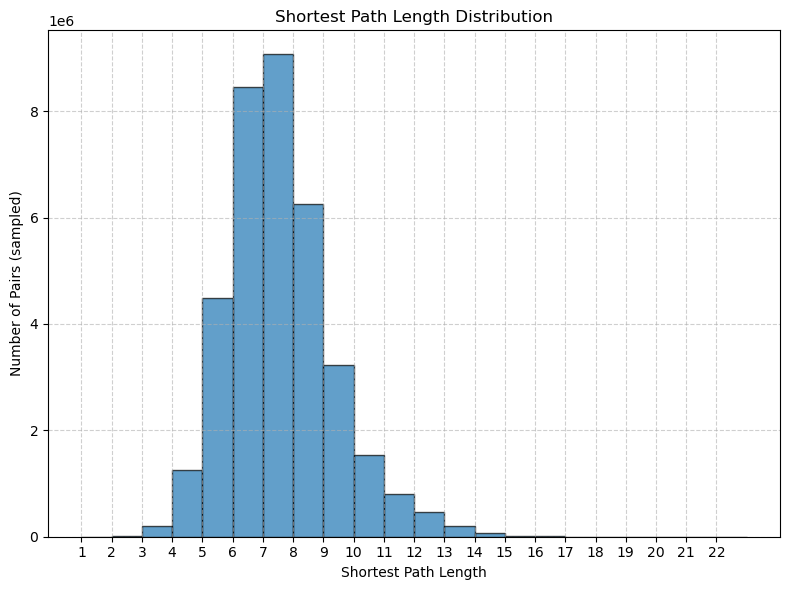

In [132]:
def compute_shortest_paths_distribution(adj_matrix, sample_fraction=0.01, seed=0):
    """Compute a sampled shortest-path length distribution for an unweighted, undirected graph.

    Notes:
    - Drops self-distances (0).
    - Average shortest path is over reachable pairs in the sampled sources.
    """
    rng = random.Random(seed)

    A = adj_matrix

    num_nodes = int(A.shape[0])
    if num_nodes == 0:
        return [], float("nan")

    num_sample_nodes = max(1, int(sample_fraction * num_nodes))
    num_sample_nodes = min(num_sample_nodes, num_nodes)

    sampled_nodes = rng.sample(range(num_nodes), num_sample_nodes)

    sampled_distances = []

    for node in sampled_nodes:
        dist_vector = shortest_path(csgraph=A, directed=False, indices=node, unweighted=True)
        finite = dist_vector[np.isfinite(dist_vector)]
        finite = finite[finite > 0]  # drop self-distance 0
        if finite.size:
            sampled_distances.extend(finite.astype(int).tolist())

    avg_shortest_path = float(np.mean(sampled_distances)) if sampled_distances else float("nan")

    return sampled_distances, avg_shortest_path


def plot_shortest_paths_distribution_bar(path_lengths):
    """Plot the shortest-path length distribution as a bar chart (integer bins)."""
    if not path_lengths:
        print("No path lengths to plot.")
        return

    path_lengths = np.asarray(path_lengths, dtype=int)
    path_lengths = path_lengths[path_lengths > 0]

    if path_lengths.size == 0:
        print("No positive path lengths to plot.")
        return

    max_len = int(path_lengths.max())
    bins = np.arange(1, max_len + 2)  # [1, 2, ..., max_len+1]

    hist, bin_edges = np.histogram(path_lengths, bins=bins)
    centers = bin_edges[:-1]

    plt.figure(figsize=(8, 6))
    plt.bar(centers, hist, width=1.0, edgecolor="black", alpha=0.7, align="edge")

    plt.xlabel("Shortest Path Length")
    plt.ylabel("Number of Pairs (sampled)")
    plt.title("Shortest Path Length Distribution")
    plt.xticks(range(1, max_len + 1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

path_lengths, avg_sp = compute_shortest_paths_distribution(A, sample_fraction=0.001, seed=0)
print(f"Average shortest path length (reachable pairs only, sampled): {avg_sp:.4f}")
plot_shortest_paths_distribution_bar(path_lengths)

# Question 1d

avg: 0.16416271704342084


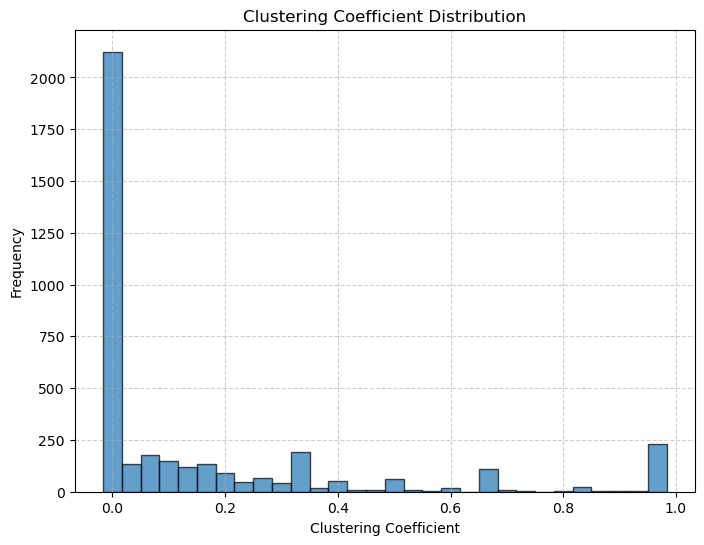

In [133]:
def compute_local_clustering(adj_matrix, sample_fraction=1.0):
    # put in CSR format
    adj_matrix = adj_matrix.tocsr()
    num_nodes = adj_matrix.shape[0]

    # sample nodes
    if sample_fraction < 1.0:
        sampled_nodes = random.sample(
            range(num_nodes),
            int(sample_fraction * num_nodes)
        )
    else:
        sampled_nodes = range(num_nodes)

    clustering_coeffs = []

    for node in sampled_nodes:
        neighbors = adj_matrix[node].indices
        k = len(neighbors)

        if k < 2:
            clustering_coeffs.append(0.0)
            continue

        # induced subgraph on neighbors
        subgraph = adj_matrix[neighbors, :][:, neighbors]
        num_edges = subgraph.nnz // 2

        # maximum possible number of edges between neighbors
        possible_edges = k * (k - 1) // 2
        # clustering coefficient for the current node
        clustering_coeffs.append(num_edges / possible_edges)

    avg_clustering = np.mean(clustering_coeffs)
    return clustering_coeffs, avg_clustering

def plot_clustering_distribution_bar(clustering_coeffs, bins=10):
    """
    Plot the clustering coefficient distribution as a bar graph.
    """
    hist, bin_edges = np.histogram(clustering_coeffs, bins=bins, range=(0, 1), density=False)

    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], hist, width=(bin_edges[1] - bin_edges[0]), edgecolor="black", alpha=0.7)
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Frequency")
    plt.title("Clustering Coefficient Distribution")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

coeffs, avg = compute_local_clustering(A, sample_fraction=0.02)
print("avg:", avg)
plot_clustering_distribution_bar(coeffs, bins=30)

# Question 1e

Spectral gap (|λ1| - |λ2|): 1.367081


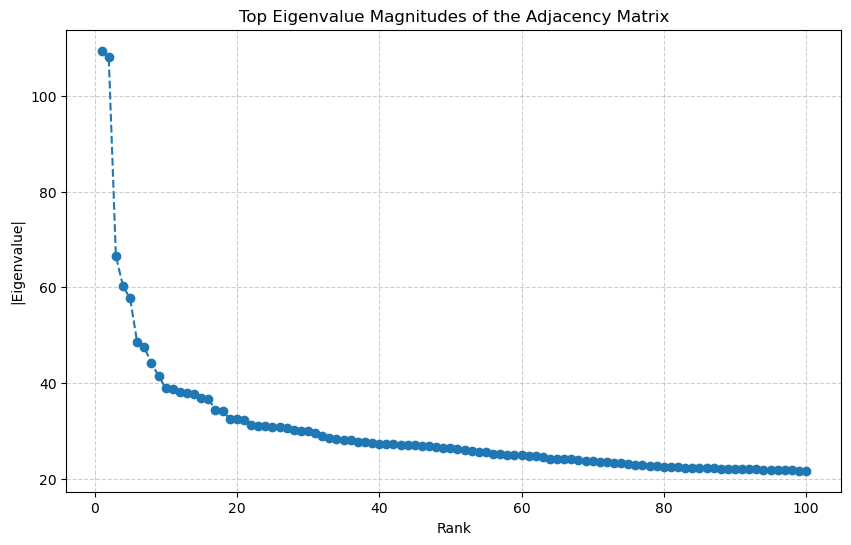

In [134]:

def compute_eigenvalues(adj_matrix, num_eigenvalues=100):
    """
    Compute the eigenvalue spectrum of the adjacency matrix (undirected => symmetric).

    Returns:
        eigvals_abs (np.ndarray): Top eigenvalue magnitudes sorted descending.
        spectral_gap (float): Spectral gap = |λ1| - |λ2|
    """
    # For symmetric adjacency matrices, eigsh is preferred over eigs
    eigvals = eigsh(adj_matrix, k=num_eigenvalues, which="LM", return_eigenvectors=False)

    # Sort by magnitude (descending)
    eigvals_abs = np.sort(np.abs(eigvals))[::-1]

    # Spectral gap as |λ1| - |λ2|
    spectral_gap = eigvals_abs[0] - eigvals_abs[1]

    return eigvals_abs, spectral_gap


def plot_eigenvalues(eigvals_abs):
    """
    Plot the top eigenvalue magnitudes |λ|.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(eigvals_abs) + 1),
        eigvals_abs,
        marker="o",
        linestyle="--",
    )
    plt.xlabel("Rank")
    plt.ylabel("|Eigenvalue|")
    plt.title("Top Eigenvalue Magnitudes of the Adjacency Matrix")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

eigvals_abs, spectral_gap = compute_eigenvalues(A, num_eigenvalues=100)
print(f"Spectral gap (|λ1| - |λ2|): {spectral_gap:.6f}")
plot_eigenvalues(eigvals_abs)

# Question 1f

Degree correlation (Pearson): 0.09763518758962628


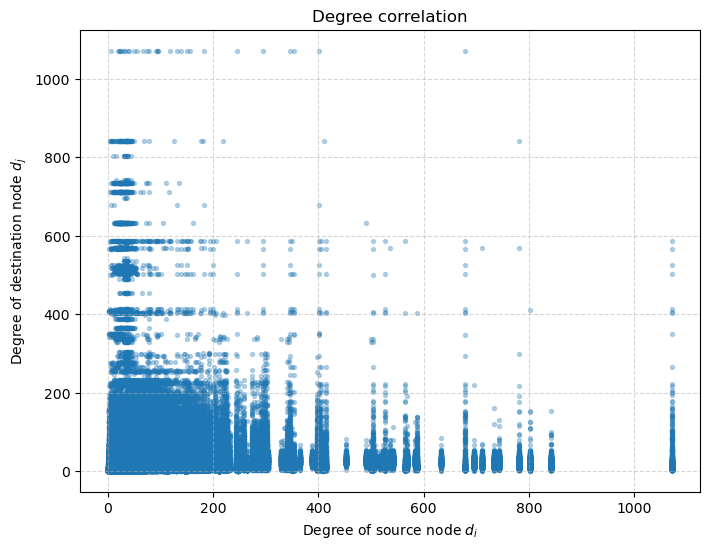

In [135]:
def compute_degrees(adj_matrix):
    """
    Compute the degrees of all nodes in the graph.
    """
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    return degrees

def compute_degree_correlation(adj_matrix, degrees):
    """
    Compute degree correlation for the network using numpy.corrcoef.

    Returns:
        di_dj_pairs (list): (degree_source, degree_destination) for each edge
        correlation (float): Pearson correlation coefficient
    """
    rows, cols = adj_matrix.nonzero()

    # keep each undirected edge once
    di_dj_pairs = [(degrees[u], degrees[v]) for u, v in zip(rows, cols) if u < v]

    di, dj = zip(*di_dj_pairs)

    # numpy.corrcoef returns a 2x2 matrix
    corr_matrix = np.corrcoef(di, dj)
    correlation = corr_matrix[0, 1]

    return di_dj_pairs, correlation

def plot_degree_correlation(di_dj_pairs):
    """
    Scatter plot of degree_source vs degree_destination.
    """
    di, dj = zip(*di_dj_pairs)

    plt.figure(figsize=(8, 6))
    plt.scatter(di, dj, s=8, alpha=0.3)
    plt.xlabel("Degree of source node $d_i$")
    plt.ylabel("Degree of destination node $d_j$")
    plt.title("Degree correlation")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

degrees = compute_degrees(A)
pairs, corr = compute_degree_correlation(A, degrees)
print("Degree correlation (Pearson):", corr)
plot_degree_correlation(pairs)